# 驗證碼辨識專案
專案目標是辨識 [Kaggle 驗證碼資料](https://www.kaggle.com/greysky/captcha-dataset)，因為這組驗證碼資料有特定的規律，圖像中每個字元都出現在特定範圍，因此，可以將驗證碼圖像均勻分割為五張圖像，分別辨識每張圖像對應的字元，而不需要使用遞迴神經網路，且辨識效果也較遞迴神經網路好。

## Step0: 前置步驟與模塊導入
請先建立專案資料夾，並下載[驗證碼圖像](https://www.kaggle.com/greysky/captcha-dataset)到該資料夾中，並進行解壓縮。

In [1]:
from platform import python_version
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import glob

print('Python Version: ', python_version())
print('TensorFlow Version: ', tf.__version__)
print('NumPy Version: ', np.__version__)
print('Pandas Version: ', pd.__version__)

Python Version:  3.7.8
TensorFlow Version:  2.4.1
NumPy Version:  1.19.5
Pandas Version:  1.2.1


## Step1: 資料探勘 (EDA)
驗證碼圖像中的每個字元剛好均勻分散在圖中。

圖片形狀: (50, 180, 3)


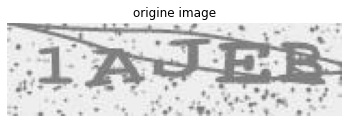

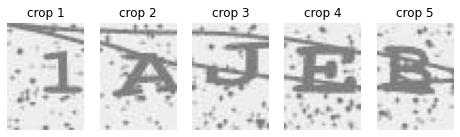

In [2]:
image = tf.keras.preprocessing.image.load_img('./dataset/1AJEB.png')
image_array = keras.preprocessing.image.img_to_array(image).astype(np.uint8)

print('圖片形狀:', image_array.shape)

plt.imshow(image_array)
plt.title('origine image')
plt.axis("off")

_, ax = plt.subplots(1, 5, figsize=(8, 2))
for i in range(5):
    img = image_array[:, int(i*image_array.shape[1]/5):(i+1)*int(image_array.shape[1]/5), :]
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title("crop " + str(i+1))
plt.show()

## Step2: 建立訓練與測試資料
專案路徑下建立 **dataset_cropped** 資料夾，並在該路徑下分別建立:
  + **train** 資料夾: 資料皆為分割後的訓練圖像
  + **test** 資料夾: 資料為原始驗證碼圖像

In [3]:
# 打亂圖像
img_files = np.array(os.listdir('./dataset/'))
indices = np.arange(len(img_files))
np.random.shuffle(indices)
img_files = img_files[indices]

# 訓練, 測試分割 
train_img_files = img_files[:1800]
test_img_file = img_files[1800:]

In [5]:
os.mkdir('./dataset_cropped/')
os.mkdir('./dataset_cropped/train')
os.mkdir('./dataset_cropped/test')

In [6]:
char_dict = {}

for img_file in train_img_files:
    # 讀取圖像 
    img = cv2.imread('./dataset/' + img_file, cv2.IMREAD_GRAYSCALE)
    # 讀取標籤 
    label = img_file[:5]
    for i in range(5):
        char = label[i]
        if char in char_dict:
            char_dict[char] += 1
        else: 
            os.mkdir('./dataset_cropped/train/' + char)
            char_dict[char] = 1
        # 切割圖像
        cropped_img = img[:,i*36:(i+1)*36]
        name = './dataset_cropped/train/' +  char + '/' + str(char_dict[char]) + '_' + char + '.png' 
        cv2.imwrite(name, cropped_img)

In [7]:
for img_file in test_img_file: 
    shutil.copy('./dataset/' + img_file, './dataset_cropped/test/' + img_file)

In [8]:
print('各字元出現頻率')
print(pd.Series(char_dict))

各字元出現頻率
2    236
G    263
V    272
7    272
Y    262
1    278
C    281
5    271
J    278
W    284
F    284
B    290
I    278
K    265
Z    294
E    244
M    256
3    285
A    286
8    284
P    261
9    263
Q    291
T    256
H    249
4    264
U    284
N    286
D    276
6    235
S    295
X    318
R    256
L      3
dtype: int64


## Step3: 增加類別 'L' 資料量
由於類別 'L' 資料量過少，使用數據增強 (Data Augmentation) 增加該類別資料量。

In [9]:
# 數據增強函數
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomZoom(1/20),
        tf.keras.layers.experimental.preprocessing.RandomHeight(1/10),
        tf.keras.layers.experimental.preprocessing.RandomWidth(1/10),
    ]
)

input_arr = [] 
for img_file in os.listdir('./dataset_cropped/train/L/'):
    image = tf.keras.preprocessing.image.load_img('./dataset_cropped/train/L/' + img_file)
    input_arr.append(keras.preprocessing.image.img_to_array(image))
input_arr = np.array(input_arr)

for i in range(80):
    output_arr = data_augmentation(input_arr)
    keras.preprocessing.image.save_img('./dataset_cropped/train/L/' + str(i*3 + 1) + '_' + 'L.png' , output_arr[0])
    keras.preprocessing.image.save_img('./dataset_cropped/train/L/' + str(i*3 + 1) + '_' + 'L.png' , output_arr[1])
    keras.preprocessing.image.save_img('./dataset_cropped/train/L/' + str(i*3 + 1) + '_' + 'L.png' , output_arr[2])

## Step4: 資料預處理

In [10]:
# 變數設定
batch_size = 32 
img_height, img_width, channel = 50, 36, 1 
num_classes = 34

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    './dataset_cropped/train/',
    labels='inferred',
    label_mode='categorical',  
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width), 
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed = 1314,
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    './dataset_cropped/train/',
    labels='inferred',
    label_mode='categorical',  
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width), 
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed = 1314,
)

def data_preprocess(img, label):
    return img/255, label

ds_train = ds_train.map(data_preprocess)
ds_validation = ds_validation.map(data_preprocess)

Found 9079 files belonging to 34 classes.
Using 8172 files for training.
Found 9079 files belonging to 34 classes.
Using 907 files for validation.


## Step5: 建立與編譯模型

In [11]:
# 建立模型
model = keras.Sequential(
    [
        keras.Input(shape=(img_height, img_width, channel)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# 編譯模型
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 7, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4928)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4928)              0         
_________________________________________________________________
dense (Dense)                (None, 256)              

## Step6: 訓練與儲存模型

In [12]:
history = model.fit(ds_train, epochs=70, validation_data=ds_validation)
model.save('captcha_solver_model.h5')

Epoch 1/70
256/256 [==============================] - 20s 74ms/step - loss: 3.3019 - accuracy: 0.1143 - val_loss: 1.1613 - val_accuracy: 0.6814
Epoch 2/70
256/256 [==============================] - 20s 76ms/step - loss: 1.0491 - accuracy: 0.7081 - val_loss: 0.4654 - val_accuracy: 0.8931
Epoch 3/70
256/256 [==============================] - 19s 75ms/step - loss: 0.5153 - accuracy: 0.8576 - val_loss: 0.2597 - val_accuracy: 0.9305
Epoch 4/70
256/256 [==============================] - 19s 75ms/step - loss: 0.3204 - accuracy: 0.9080 - val_loss: 0.2234 - val_accuracy: 0.9405
Epoch 5/70
256/256 [==============================] - 19s 75ms/step - loss: 0.2522 - accuracy: 0.9216 - val_loss: 0.1657 - val_accuracy: 0.9581
Epoch 6/70
256/256 [==============================] - 20s 77ms/step - loss: 0.1868 - accuracy: 0.9456 - val_loss: 0.1418 - val_accuracy: 0.9713
Epoch 7/70
256/256 [==============================] - 21s 80ms/step - loss: 0.1506 - accuracy: 0.9533 - val_loss: 0.1348 - val_accuracy:

256/256 [==============================] - 21s 83ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0621 - val_accuracy: 0.9857
Epoch 58/70
256/256 [==============================] - 21s 83ms/step - loss: 0.0257 - accuracy: 0.9920 - val_loss: 0.0745 - val_accuracy: 0.9846
Epoch 59/70
256/256 [==============================] - 21s 82ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0685 - val_accuracy: 0.9857
Epoch 60/70
256/256 [==============================] - 21s 82ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.0645 - val_accuracy: 0.9868
Epoch 61/70
256/256 [==============================] - 21s 82ms/step - loss: 0.0245 - accuracy: 0.9902 - val_loss: 0.0749 - val_accuracy: 0.9868
Epoch 62/70
256/256 [==============================] - 24s 94ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0662 - val_accuracy: 0.9890
Epoch 63/70
256/256 [==============================] - 22s 84ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0746 - val_accuracy: 0.98

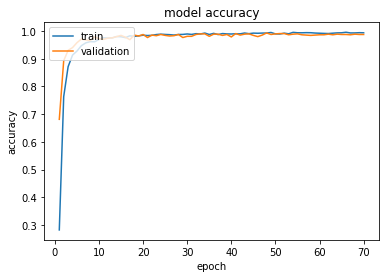

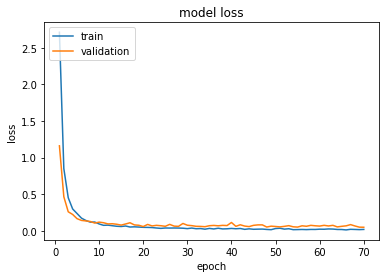

In [13]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epoch_list = [i+1 for i in range(len(loss))]


plt.plot(epoch_list, accuracy)
plt.plot(epoch_list, val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(epoch_list, loss)
plt.plot(epoch_list, val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Step7: 模型預測

In [14]:
labels = os.listdir('./dataset_cropped/train/')

def my_predict(img_path): 
    image = tf.keras.preprocessing.image.load_img(img_path, color_mode ='grayscale')
    image_array = keras.preprocessing.image.img_to_array(image)
    image_array = image_array/255
    res = []
    for i in range(5): 
        sub_image_array = np.expand_dims(image_array[:, i*36:(i+1)*36,:],axis=0)
        index = np.argmax(model.predict(sub_image_array))
        char = labels[index]
        res.append(char)
    return ''.join(res)

In [15]:
correct_num = 0 
for img_file in os.listdir('./dataset_cropped/test/'): 
    if my_predict('./dataset_cropped/test/' + img_file) == img_file[:5]:
        correct_num += 1

print('測試準確度:', correct_num/len(os.listdir('./dataset_cropped/test/')))

測試準確度: 0.915
